**SD NQBit**

In [1]:
%autosave 1
import numpy as np
import warnings
from quspin.operators import hamiltonian
from quspin.basis import spin_basis_1d
from numpy import linalg as LA
import matplotlib.pyplot as plt
from scipy.constants import hbar
warnings.filterwarnings("ignore")
from functools import reduce
from math import sqrt
from random import gauss, uniform
from random import choices
from random import uniform
from tqdm import tnrange
from copy import deepcopy

Autosaving every 1 seconds


In [2]:
def hamiltonian(L,g=1,hx=1):
    H1 = np.zeros((2**L,2**L))
    H2 = np.zeros((2**L,2**L))
    H3 = np.zeros((2**L,2**L))
    
    for j in range(L-1):   
        H1 = np.kron(np.identity(2**j),sigma3_tensor)
        H1 = np.kron(H1,np.identity(2**(L-j-2)))
    
    for i in range(L):
        
        H3 = np.kron(np.identity(2**i),sigma1)
        H3 = np.kron(H3,np.identity(2**(L-i-1)))
        H2 = np.kron(np.identity(2**i),sigma3)
        H2 = np.kron(H2,np.identity(2**(L-i-1)))
    
    H = H1 + g*H2 + hx*H3
    return H 

def coefficients_wave_functions(L):
    coefficients = np.array([gauss(0.0, 1.0) for _ in range(2**(L+1))])
    norm = sqrt(reduce(lambda sum,x: sum + x*x, coefficients, 0.0))
    real = np.split(coefficients, 2)[0]
    imag = np.split(coefficients, 2)[1]
    return np.array([real / norm + 1.j*(imag / norm) for real,imag in zip(real,imag)],dtype=np.complex128)

def modulus_squared_inner_product(psi1,psi2):
    modulus=np.abs(np.dot(np.conj(psi1.T),psi2))
    return modulus**2

def update_state(eigenvectors,eigenvalues,psi_in,T):
    
    c_i = np.array([np.dot(eigenvectors[:,i],psi_in) for i in range(len(psi_in))]) 
    psi_rec = []
    for i in range(len(psi_in)):
        psi_rec.append(c_i[i]*np.exp((-1j*eigenvalues[i]*T)/hbar)*eigenvectors[i])
    return np.array(psi_rec).sum(axis=0)

[Libreria di riferimento](http://weinbe58.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html)

We want to write a chain of L coupled qubits:
$$H[h_x(t)] = - \sum_{j=1}^L(S^z_{j+1}S^z_j+gS^z_j+h_x(t)S^x_j)$$
as in the article we set g=1. 

In the particoular case of single qubit we remove the first term J=0: 

$$H[h_x(t)] = - S^z_j - h_x(t)S^x_j$$

In [3]:
NQUBITS = 2

In [4]:
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1.j],[1.j,0]])
sigma3=np.array([[1,0],[0,-1]])
sigma3_tensor= np.kron(sigma3,sigma3)

**STOCHASTIC DESCENT**
1. Start from a random protocol and proposes local field updates at time t choosing uniformly in the interval [0,T].
2. Magnetic field is changed only if increase the fidelity.
3. Number of fidelity evaluation at most $$20 \times T/\delta t$$
4. Repeat with different initial random protocols.

The set of protocols {$h^{\alpha}|\alpha= 1, \dots, N_{real}$} used to calculate the glass-like order parameter.

In [5]:
TMAX = 1
Δt = 0.01
NSTEPS = int(TMAX/Δt) # protocol lenght
ITERATIONS = 3*int(1e3)

print("Total time of the protocol:", TMAX)
print("Time step:", Δt)
print("Number of timesteps:", NSTEPS)

LIMIT_FED_EVAL=20*TMAX/Δt # set by paper authors

Total time of the protocol: 1
Time step: 0.01
Number of timesteps: 100


**SPECTRAL METHOD**

First method to evolve the system:

$$|\psi(T)> = \sum_{i=0}^{L-1} c_i exp[-i E_i T / \hbar] |E_i>$$

In [6]:
N_QUBITS = [2,3,4,5]
fidelity_values = [ ]
for NQUBITS in N_QUBITS:
    
    hamiltonian_plus4 = hamiltonian(L=NQUBITS,hx=4)
    hamiltonian_minus4 = hamiltonian(L=NQUBITS,hx=-4)
    val_H_plus4,vec__H_plus4, = LA.eig(hamiltonian_plus4)
    val_H_minus4,vec__H_minus4, = LA.eig(hamiltonian_minus4)

    np.random.seed(213)

    hx = [-4,4]

    random_protocol = np.array(choices(hx, k=NSTEPS)) # Define a random protocol, sampling without replacement from a list. 
    temp_protocol=deepcopy(random_protocol)
    # angle_phase_iniz = uniform(0,2*np.pi)
    # angle_phase_target = uniform(0,2*np.pi) 
    psi_start = coefficients_wave_functions(L=NQUBITS) # Start from a random 2^L state 
    psi_target = coefficients_wave_functions(L=NQUBITS)  # Remember to change first component when things will work.

    fidelity = modulus_squared_inner_product(psi_target,psi_start)
#     fidelity_values = [fidelity]

    psi_start.shape
    vec__H_minus4.shape

    warnings.filterwarnings("ignore")
    percentage_flip=25
    print("--------------------------------> RESULTS FOR ",NQUBITS,"QUBITS <-------------------------------------------- ")
    for j in tnrange(ITERATIONS):
        psi_iniz=deepcopy(psi_start)
        index_update = np.random.randint(0, NSTEPS-1,size=int(NSTEPS/100*percentage_flip)) # Select an index for the update.
        temp_protocol[index_update] = random_protocol[index_update]*(-1) # Try to update that index.

        for i in temp_protocol:  # Evolve the random state according to the protocol
            if i<0:
                psi_iniz = update_state(vec__H_minus4,val_H_minus4, psi_iniz,Δt)
            else:
                psi_iniz = update_state(vec__H_plus4,val_H_plus4, psi_iniz,Δt)

        temp_fidelity = modulus_squared_inner_product(psi_target,psi_iniz) # Evaluate the fidelity
        if temp_fidelity>fidelity: # Update the change only if better fidelity
            random_protocol=deepcopy(temp_protocol)
            fidelity=temp_fidelity
            print("UPDATE  ", "ITERATION N°",j )
            best_reached_state = psi_iniz
#         fidelity_values.append(fidelity)

    print(" ")
    print("FINAL FIDELTY FOR",NQUBITS,"QUBITS",modulus_squared_inner_product(psi_target,best_reached_state) ) 
    print("FINAL RECONSTRUCTED STATE", best_reached_state) 
    fidelity_values.append(fidelity)

--------------------------------> RESULTS FOR  2 QUBITS <-------------------------------------------- 


UPDATE   ITERATION N° 0
UPDATE   ITERATION N° 2
UPDATE   ITERATION N° 11
UPDATE   ITERATION N° 16
UPDATE   ITERATION N° 22

 
FINAL FIDELTY FOR 2 QUBITS 0.8896556413691503
FINAL RECONSTRUCTED STATE [ 0.20356545+0.50753032j -0.5527191 +0.09763327j -0.18908408+0.29715824j
  0.07490729+0.50623761j]
--------------------------------> RESULTS FOR  3 QUBITS <-------------------------------------------- 


UPDATE   ITERATION N° 0
UPDATE   ITERATION N° 8
UPDATE   ITERATION N° 24
UPDATE   ITERATION N° 25

 
FINAL FIDELTY FOR 3 QUBITS 0.4217974160445827
FINAL RECONSTRUCTED STATE [-0.34700346+0.29970552j  0.31290121+0.06491087j  0.09257935-0.15282784j
 -0.43162214+0.04115203j -0.41205947+0.30891999j  0.04050563-0.21881076j
  0.25262089+0.10891022j  0.19275412+0.20037426j]
--------------------------------> RESULTS FOR  4 QUBITS <-------------------------------------------- 


UPDATE   ITERATION N° 2
UPDATE   ITERATION N° 5
UPDATE   ITERATION N° 6

 
FINAL FIDELTY FOR 4 QUBITS 0.2372612585678413
FINAL RECONSTRUCTED STATE [ 0.12395585-0.08135109j  0.08036596-0.13950822j  0.08025771-0.22724325j
  0.00108119+0.03910205j  0.03371143+0.19903258j  0.27494468+0.27983175j
  0.1478864 -0.00066487j -0.14602885-0.07264837j -0.11892111-0.11333807j
 -0.11319066+0.11975246j -0.19426681+0.02768786j  0.11549308-0.10430189j
 -0.07949988+0.13182189j -0.36610642+0.08482445j  0.171134  +0.46484142j
  0.02212647-0.3488787j ]
--------------------------------> RESULTS FOR  5 QUBITS <-------------------------------------------- 


UPDATE   ITERATION N° 0
UPDATE   ITERATION N° 1
UPDATE   ITERATION N° 2
UPDATE   ITERATION N° 8
UPDATE   ITERATION N° 9

 
FINAL FIDELTY FOR 5 QUBITS 0.08097395580128605
FINAL RECONSTRUCTED STATE [ 0.15980178+0.05183234j -0.02614047+0.16398597j  0.2976103 -0.05783864j
 -0.03220041-0.13880968j -0.00481555-0.00635623j -0.06921029-0.07211638j
  0.05283149-0.01577523j -0.10374085+0.10641077j -0.0986588 -0.12021088j
 -0.38590201+0.05063077j  0.02626494+0.11284406j  0.02791228+0.03054251j
  0.03197459-0.03405943j  0.09024541+0.12990919j -0.11270084-0.11457442j
  0.05282173-0.31016848j  0.09556631-0.1178626j   0.03192628+0.00437622j
 -0.06616391-0.13621499j  0.04123482+0.26356888j  0.07497046-0.02899495j
 -0.04073362+0.20581189j  0.04350301-0.07006048j  0.03714483-0.05539171j
 -0.13058357-0.00040678j  0.04681254+0.0708743j  -0.15306196+0.13754656j
  0.01485896-0.16161383j  0.0787395 +0.18372699j -0.16869582+0.04676621j
  0.18816117+0.21862549j -0.12635329-0.10656704j]


In [9]:
fidelity_values

[0.8896556413691503,
 0.4217974160445827,
 0.2372612585678413,
 0.08097395580128605]

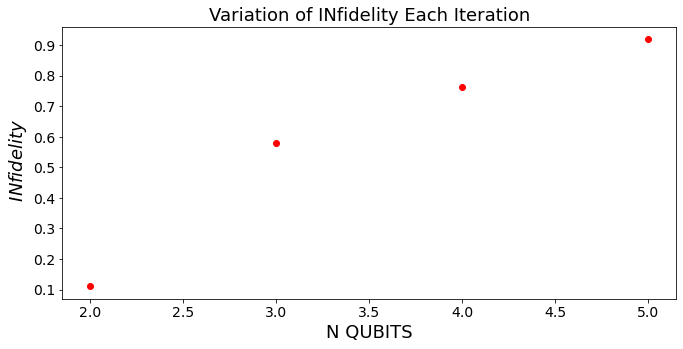

In [18]:
fig, ax = plt.subplots(figsize=(11,5))
ax.scatter(2+np.arange(len(fidelity_values)),1-np.array(fidelity_values),color='r')
ax.set_title(r"Variation of INfidelity Each Iteration", fontsize=18)
ax.set_xlabel("N QUBITS", fontsize=18)
ax.set_ylabel(r" $INfidelity$", fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=14) 